In [1]:
import requests
import sys
sys.path.append('src')
from paco.parser.parse_tree import ParseTree
from paco.execution_tree.execution_tree import ExecutionTree
from paco.explainer.bdd.bdds import bdds_from_json

headers = {
	"Content-Type": "application/json",
}
url = "http://127.0.0.1:8000/"

### Define and Check BPMN

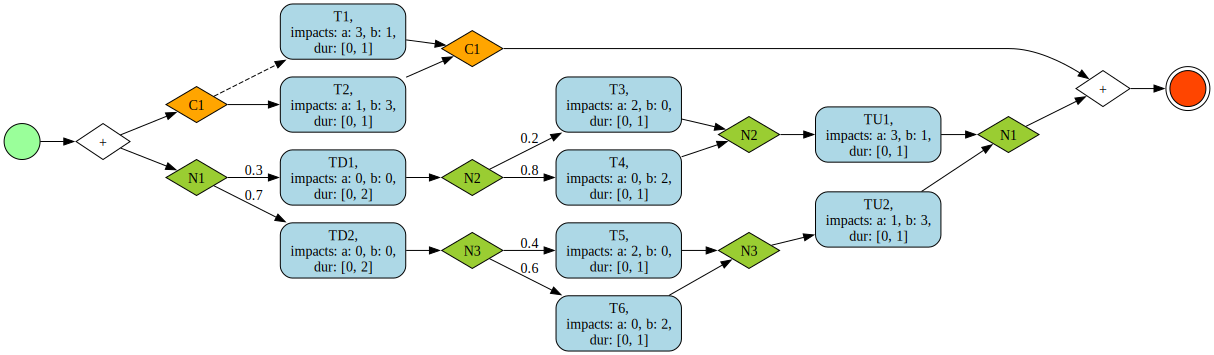

In [2]:
from utils.env import EXPRESSION, IMPACTS, DURATIONS, IMPACTS_NAMES, PROBABILITIES, DELAYS, LOOP_PROBABILITY, LOOP_ROUND, H
import graphviz
from IPython.display import display, SVG

expression = '((T1 /[C1] T2) || ((TD1, (T3 ^[N2] T4), TU1) ^[N1] (TD2,  (T5 ^[N3] T6), TU2)))'

bpmn = {
	EXPRESSION: expression,
	IMPACTS_NAMES: ['a', 'b'],
	IMPACTS: {'T1': [3, 1], 'T2': [1, 3], 'T3': [2, 0], 'T4': [0, 2], 'TU1': [3, 1], 'T5': [2, 0], 'T6': [0, 2], 'TU2': [1, 3], 'TD1': [0, 0], 'TD2': [0, 0]},
	DURATIONS: {'T1': [0, 1], 'T2': [0, 1], 'T3': [0, 1], 'T4': [0, 1], 'TU1': [0, 1], 'T5': [0, 1], 'T6': [0, 1], 'TU2': [0, 1], 'TD1': [0, 2], 'TD2': [0, 2]},
	PROBABILITIES: {'N2': 0.2, 'N1': 0.3, 'N3': 0.4},
	LOOP_PROBABILITY: {},
	DELAYS: {'C1': 1}, LOOP_ROUND: {}, H: 0,
}

try:
	resp = requests.get(f'{url}create_bpmn', json={'bpmn': bpmn},  headers=headers)
	resp.raise_for_status()
	display(SVG(graphviz.Source(resp.json()['bpmn_dot']).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

### Create the Execution tree

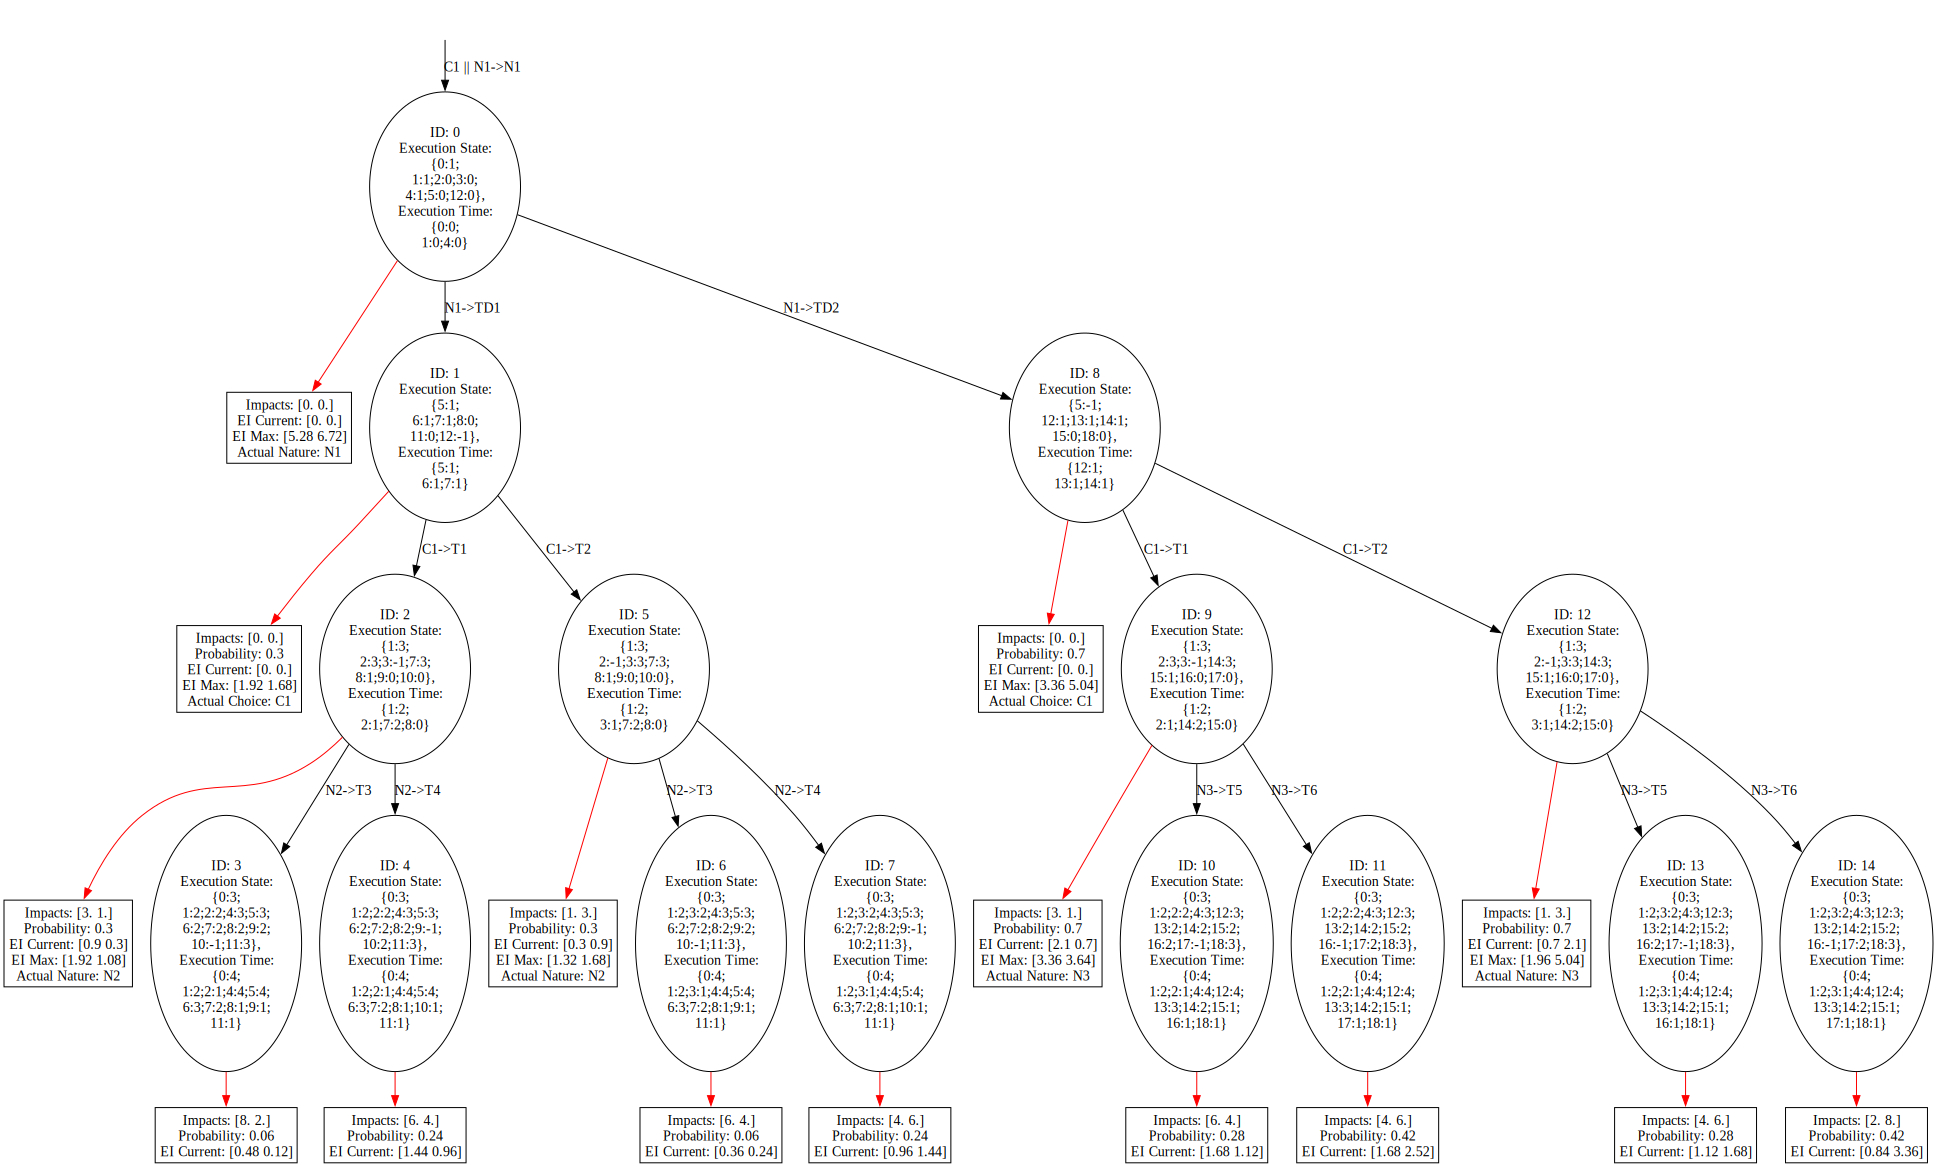

In [3]:
execution_tree = None
try:
	resp = requests.get(f'{url}create_execution_tree', json={"bpmn": bpmn},  headers=headers)
	resp.raise_for_status()

	response = resp.json()
	parse_tree, _,_ = ParseTree.from_json(response["parse_tree"], len(bpmn["impacts_names"]), 0)

	execution_tree = ExecutionTree.from_json(parse_tree, response["execution_tree"], bpmn["impacts_names"])
	dot = execution_tree.to_dot(state=True, executed_time=True, diff=True)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())

This is the strategy, with an expected impact of: a: 4.68 b: 5.32


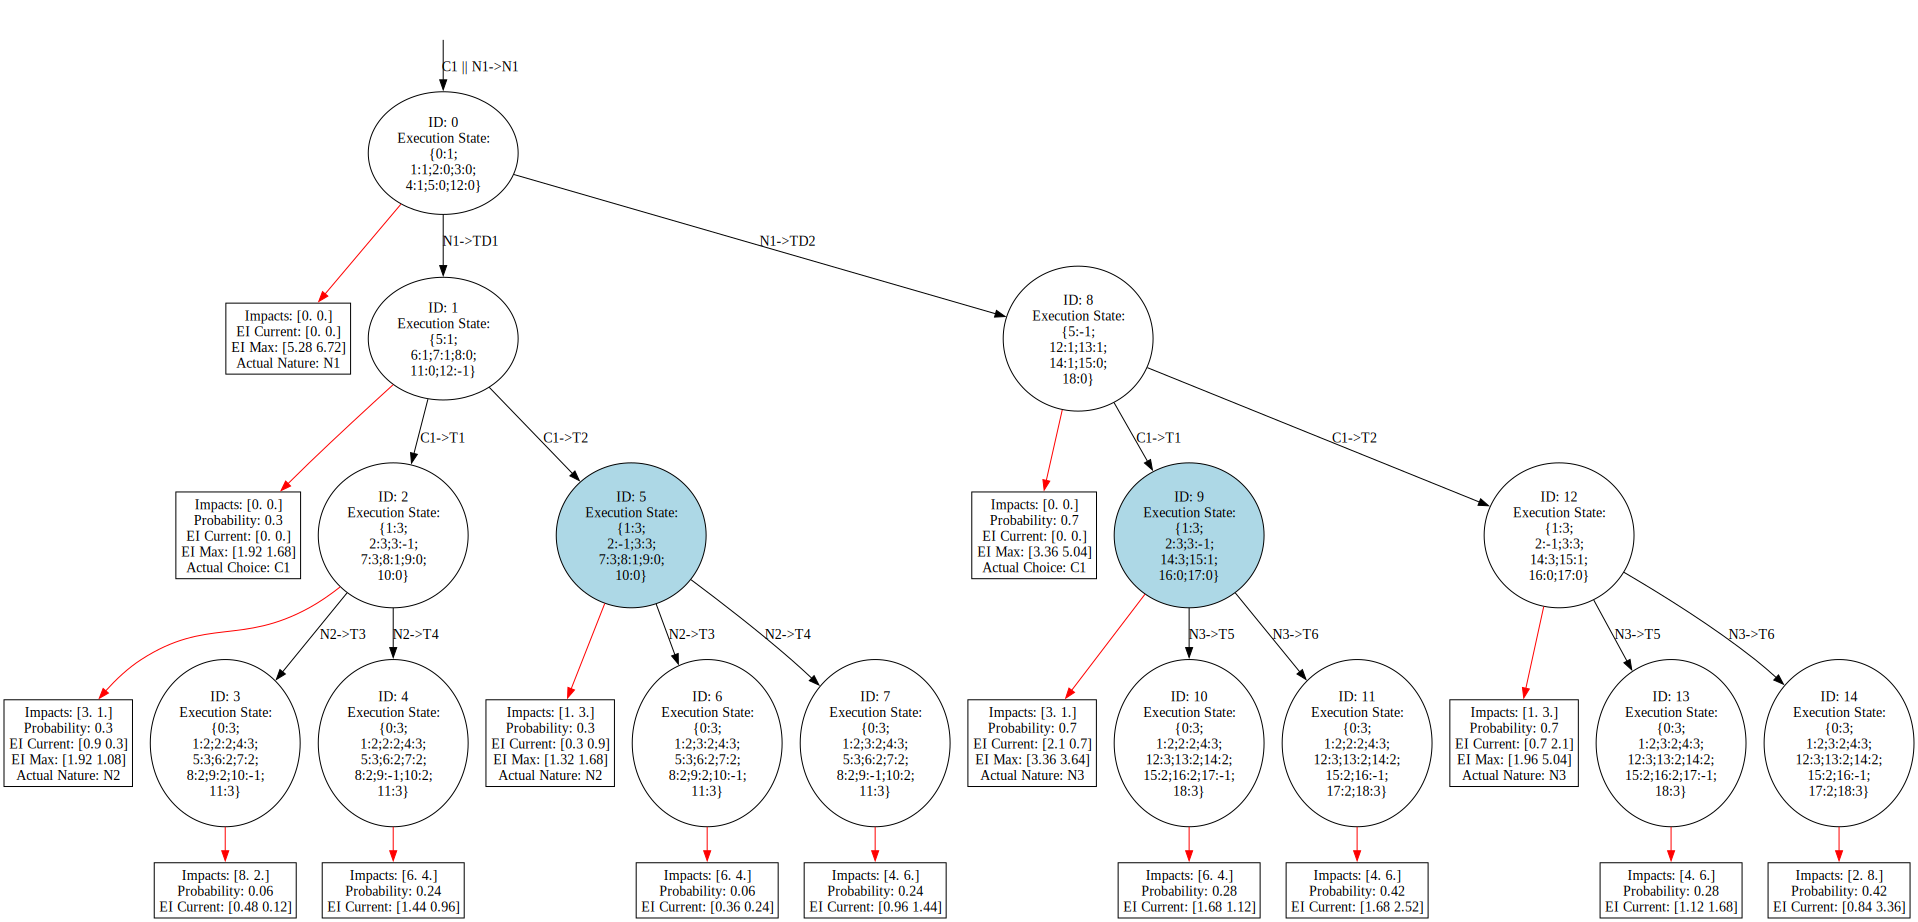

1 is dashed line of BPMN or Parse Tree
C1: UNAVOIDABLE_IMPACTS


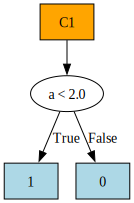

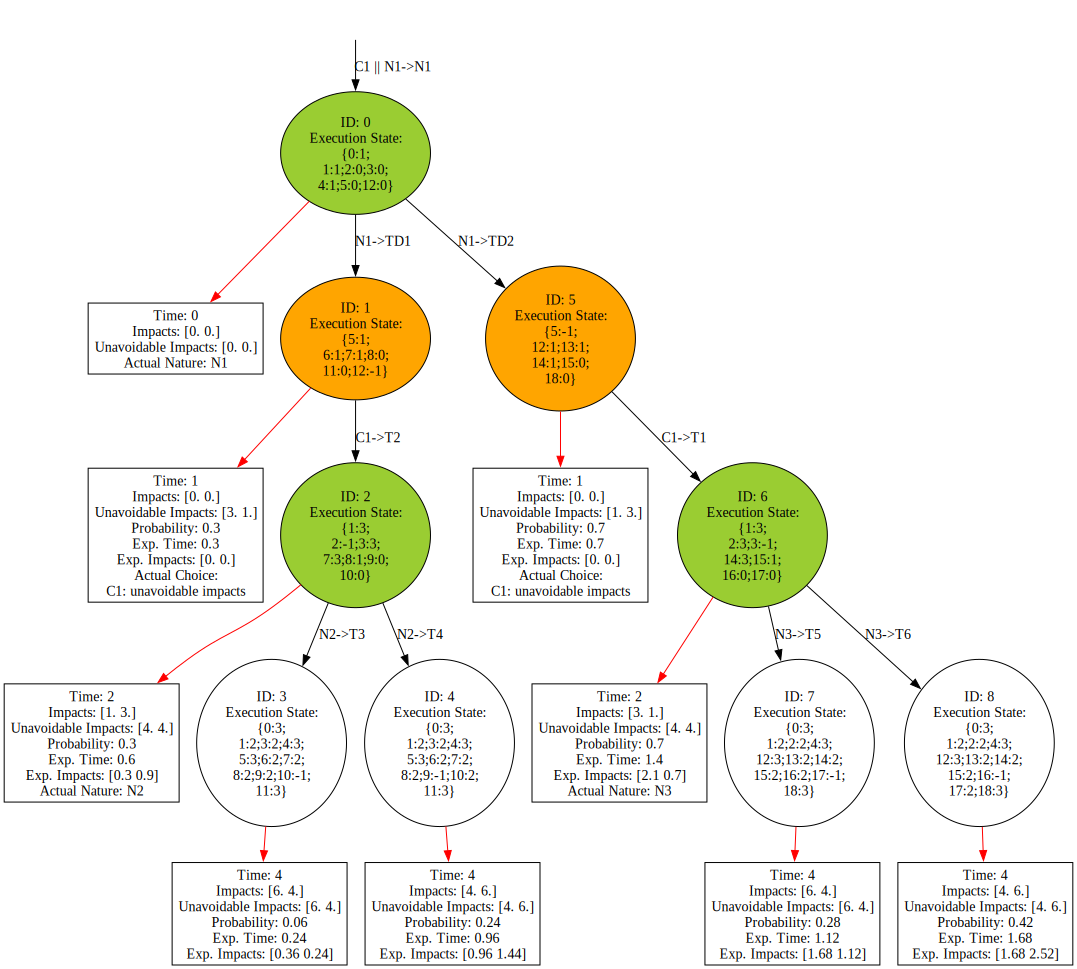

In [4]:
try:
	bound = [5.0, 6.0]

	resp = requests.get(f'{url}create_strategy', json={"bpmn": bpmn, "bound": bound, "parse_tree": parse_tree.to_dict(), "execution_tree": execution_tree.to_dict()}, headers=headers)
	resp.raise_for_status()

	response = resp.json()
	print(response["result"])

	frontier_solution_id = set()
	if "frontier_solution" in response: # Solution Found
		frontier_solution_id = set(map(int, response["frontier_solution"].strip("[]").split(",")))

	# With frontier node in blue
	dot = execution_tree.to_dot(state=True, executed_time=False, diff=True, frontier=frontier_solution_id)
	display(SVG(graphviz.Source(dot).pipe(format="svg")))

	if "strategy_tree" in response:
		explained_choices = bdds_from_json(parse_tree, response["bdds"])
		print("1 is dashed line of BPMN or Parse Tree")
		for choice, bdd in explained_choices.items():
			print(f"{choice.name}: {bdd.typeStrategy}")
			svg_data = graphviz.Source(bdd.bdd_to_dot()).pipe(format="svg")
			display(SVG(svg_data))

		strategy_tree = ExecutionTree.from_json(parse_tree, response["strategy_tree"], bpmn["impacts_names"], explained_choices)

		#TREE_STATE
		dot = strategy_tree.to_dot(state=True, executed_time=False, diff=True)
		display(SVG(graphviz.Source(dot).pipe(format="svg")))

except requests.exceptions.HTTPError as e:
	print(f"HTTP Error ({resp.status_code}):", resp.json())